In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 
EPOCHS_BASE = 50 #or 100
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
#folder = "./Sentiment/twitter/"
folder = "./Sentiment/rotten//"

### Load Data and preprocess

In [4]:
import re
FLAGS = re.MULTILINE | re.DOTALL
def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"
def tokenize(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\S+", "<hashtag>")
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    text = re_sub(r"([A-Z]){2,}", allcaps)
    return text.lower()

def read_texts(filename):
    f = open(filename)
    data = [line.strip() for line in f]
    f.close()
    return data

#texts_train = [tokenize(text) for text in read_texts(folder+"texts_train.txt")]
texts_train = read_texts(folder+"texts_train.txt")
#texts_test = [tokenize(text) for text in read_texts(folder+"texts_test.txt")]
texts_test = read_texts(folder+"texts_test.txt")

Z_train = np.loadtxt(folder+"sent_train.txt", dtype='int')
Z_test = np.loadtxt(folder+"sent_test.txt", dtype='int')

print("Num. train texts: %d" % len(texts_train))
print("Num. test texts:  %d" % len(texts_test))

Num. train texts: 4999
Num. test texts:  3999


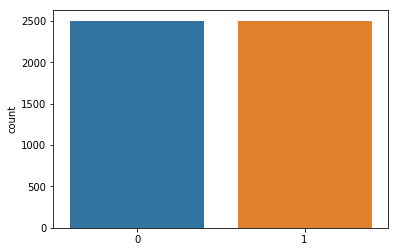

In [5]:
sns.countplot(Z_train)
plt.show()

In [5]:
from keras import preprocessing
MAX_NB_WORDS = 14000
tokenizer = preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_train+texts_test)
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)
#MAX_NB_WORDS = len(tokenizer.word_index)
print('Found %s unique tokens.' % len(tokenizer.word_index))

Found 14096 unique tokens.


(-100, 13000)

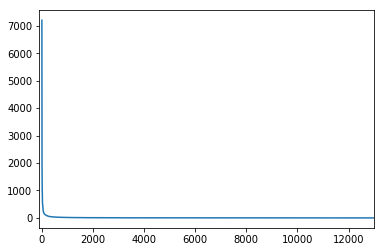

In [6]:
aux = np.asarray(list(tokenizer.word_counts.values()))
plt.plot(np.sort(aux)[::-1])
plt.xlim(-100,MAX_NB_WORDS)

In [6]:
lens = list(map(len,sequences_train))
max_L = np.max(lens)
print("Real max: ",max_L)
max_L = 50 
print("Used max: ",max_L)

X_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=max_L,dtype='int32', value=0,padding='pre')
X_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_L,dtype='int32', value=0,padding='pre')
print('Shape of train tensor:', X_train.shape)

Real max:  51
Used max:  50
Shape of train tensor: (4999, 50)


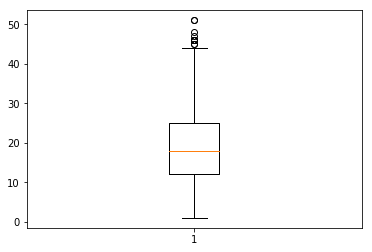

In [12]:
plt.boxplot(lens)
plt.show()

In [7]:
EMBEDDING_DIM = 300
GLOVE_FILE = "../GLOVE/glove.6B.%dd.txt"%(EMBEDDING_DIM)
#GLOVE_FILE = "../AUX_DATA/glove.twitter.27B/glove.twitter.27B.%dd.txt"%(EMBEDDING_DIM)

embeddings_index = {}
with open(GLOVE_FILE) as file:
    for line in file:
        values = line.split()
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[values[0]] = coefs
print('Preparing embedding matrix.')
sorted_x = sorted(tokenizer.word_counts.items(), key=lambda kv: kv[1], reverse=True)
vocab = {value[0]:tokenizer.word_index[value[0]] for i, value in enumerate(sorted_x) if i < MAX_NB_WORDS}
embedding_matrix = np.zeros((len(vocab)+1, EMBEDDING_DIM))
v=0
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector # words not found in embedding index will be all-zeros.
        v+=1
del embeddings_index, sorted_x, tokenizer
gc.collect()
print("Words found on glove: ",v)

Preparing embedding matrix.
Words found on glove:  12935


### Load annotations / Generate

In [8]:
from code.representation import *
from code.utils import *

In [9]:
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt", delimiter=' ', dtype='int16')
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N,T = y_obs.shape
Kl = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",Kl)

Loading AMT data...
Shape (data,annotators):  (4999, 203)
Classes:  2


In [10]:
#generate conf matrix...
confe_matrix_R = np.zeros((T,Kl,Kl),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix_R[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix_R[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix_R[t,:,:][~mask_nan],axis=0)
    for value in np.arange(Kl)[mask_nan]:
        confe_matrix_R[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
    confe_matrix_R[t,:,:] = confe_matrix_R[t,:,:]/confe_matrix_R[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix_R

array([[[0.7058824 , 0.29411766],
        [0.33333334, 0.6666667 ]],

       [[0.94827586, 0.05172414],
        [0.13733906, 0.86266094]],

       [[0.9756098 , 0.02439024],
        [0.10526316, 0.8947368 ]],

       [[0.9306358 , 0.06936416],
        [0.07629428, 0.9237057 ]],

       [[0.94011974, 0.05988024],
        [0.22839506, 0.77160496]],

       [[0.6469111 , 0.3530889 ],
        [0.16083916, 0.83916086]],

       [[0.9344    , 0.0656    ],
        [0.07922272, 0.92077726]],

       [[0.8918919 , 0.10810811],
        [0.11267605, 0.8873239 ]],

       [[0.625     , 0.375     ],
        [0.3809524 , 0.61904764]],

       [[0.81389576, 0.18610422],
        [0.13315926, 0.8668407 ]],

       [[0.8372093 , 0.1627907 ],
        [0.22891566, 0.7710843 ]],

       [[0.89830506, 0.10169491],
        [0.06      , 0.94      ]],

       [[0.9122807 , 0.0877193 ],
        [0.14655173, 0.8534483 ]],

       [[0.9301165 , 0.06988353],
        [0.12522046, 0.8747795 ]],

       [[0.7702703 ,

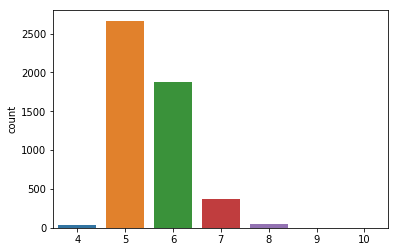

Minimum annotations in a example:  4
Maximum annotations in a example:  10
T data (expected value):  5.550310062012403
Graphics of T weights


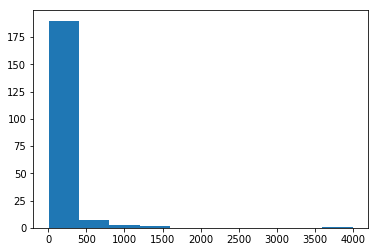

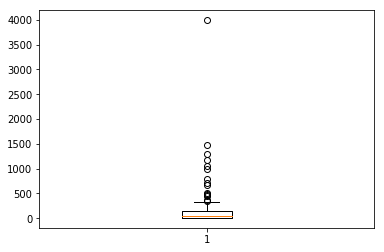

Minimum annotations by an annotator:  5
Maximum annotations by an annotator:  3993
Mean annotations by an annotator:  136.67980295566502


In [11]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

#### Delta Convergence criteria

In [11]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN_text,default_CNN_text, Clonable_Model

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [12]:
Z_train_onehot = keras.utils.to_categorical(Z_train)

model_UB = default_RNN_text(max_L, Kl, embed_M=embedding_matrix)
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist = model_UB.fit(X_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
clone_UB = Clonable_Model(model_UB)
Z_train_pred = model_UB.predict_classes(X_train)
Z_test_pred = model_UB.predict_classes(X_test)

Trained IDeal Model, Epochs to converge = 48


In [11]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'mv')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_test_onehot = keras.utils.to_categorical(Z_test)

Representation for MV in 0.097395 sec
Estimation MV in 0.000410 sec


In [12]:
from keras.models import Sequential,Model
from keras.layers import *
def default_CNN_text(input_dim,output_dim,embed_M=[]):
    model = Sequential() 
    if len(embed_M) != 0:
        T, R_t = embed_M.shape
        emd_layer = Embedding(T, R_t,trainable=False,weights=[embed_M],input_length=input_dim)
        model.add(emd_layer)
    else:
        model.add(InputLayer(input_shape=input_dim))
    model.add(Conv1D(128, 3, activation='relu')) #kernel 5?
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))
    
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))
    
    model.add(GlobalAveragePooling1D())
    
    #model.add(Flatten())
    #model.add(Dense(32, activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.25))
    
    model.add(Dense(output_dim, activation='softmax')) 
    return model
## muy parecida a la recurrente-.--

In [34]:
def default_RNN2_text(input_dim,output_dim,embed_M=[]): 
    model = Sequential() 
    if len(embed_M) != 0:
        T, R_t = embed_M.shape
        emd_layer = Embedding(T, R_t,trainable=False,weights=[embed_M],input_length=input_dim)
        model.add(emd_layer)
    else:
        model.add(InputLayer(input_shape=input_dim))
    #model.add(Dropout(0.2))
    
    layer_gru1 = GRU(128,return_sequences=True) #, dropout=0.2, recurrent_dropout=0.5)
    #model.add(Bidirectional(layer_gru1)) 
    model.add(layer_gru1)
    
    model.add(Dropout(0.5))
    
    layer_gru2 = GRU(64,return_sequences=False) #, dropout=0.2, recurrent_dropout=0.5)
    #model.add(Bidirectional(layer_gru2)) #128 funciona con embd 100 (sin otra capa)
    model.add(layer_gru2) #128 funciona con embd 100 (sin otra capa)
    
    #model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    #model.add(Dense(32, activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    
    model.add(Dense(output_dim, activation='softmax'))     
    return model

In [24]:
### como hacer modelo "no tan potente"

In [35]:
model_UB = default_RNN2_text(max_L, Kl, embed_M=embedding_matrix)
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["accuracy"])
model_UB.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 300)           4200300   
_________________________________________________________________
gru_9 (GRU)                  (None, 50, 128)           164736    
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
gru_10 (GRU)                 (None, 64)                37056     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 4,402,222
Trainable params: 201,922
Non-trainable params: 4,200,300
____________________________________________________________

In [36]:
hist=model_UB.fit(X_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=2,callbacks=[ourCallback]
                  ,validation_data=(X_test,Z_test_onehot))
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))

Train on 4999 samples, validate on 3999 samples
Epoch 1/50
 - 10s - loss: 0.6536 - acc: 0.6101 - val_loss: 0.5954 - val_acc: 0.6994
Epoch 2/50
 - 8s - loss: 0.5540 - acc: 0.7131 - val_loss: 0.5655 - val_acc: 0.7169
Epoch 3/50
 - 8s - loss: 0.4932 - acc: 0.7648 - val_loss: 0.5722 - val_acc: 0.6997
Epoch 4/50
 - 8s - loss: 0.4608 - acc: 0.7868 - val_loss: 0.5408 - val_acc: 0.7287
Epoch 5/50
 - 8s - loss: 0.4562 - acc: 0.7882 - val_loss: 0.5489 - val_acc: 0.7249
Trained IDeal Model, Epochs to converge = 5


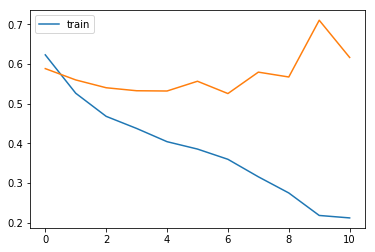

In [19]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

In [16]:
model_UB = default_RNN_text(max_L, Kl, embed_M=embedding_matrix)
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["accuracy"])
hist=model_UB.fit(X_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=2#,callbacks=[ourCallback]
                  ,validation_split=0.2)
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))

Train on 3999 samples, validate on 1000 samples
Epoch 1/50
 - 6s - loss: 0.6404 - acc: 0.6212 - val_loss: 0.5651 - val_acc: 0.7000
Epoch 2/50
 - 5s - loss: 0.5248 - acc: 0.7434 - val_loss: 0.5077 - val_acc: 0.7400
Epoch 3/50
 - 5s - loss: 0.4782 - acc: 0.7789 - val_loss: 0.4968 - val_acc: 0.7510
Epoch 4/50
 - 5s - loss: 0.4471 - acc: 0.7869 - val_loss: 0.5376 - val_acc: 0.7360
Epoch 5/50
 - 5s - loss: 0.4137 - acc: 0.8180 - val_loss: 0.4922 - val_acc: 0.7590
Epoch 6/50
 - 5s - loss: 0.3765 - acc: 0.8327 - val_loss: 0.5251 - val_acc: 0.7520
Epoch 7/50
 - 5s - loss: 0.3341 - acc: 0.8572 - val_loss: 0.5751 - val_acc: 0.7470
Epoch 8/50


KeyboardInterrupt: 

In [20]:
model_mvsoft = default_RNN_text(max_L, Kl, embed_M=embedding_matrix)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["accuracy"])
hist=model_mvsoft.fit(X_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=2,callbacks=[ourCallback]
                     #,validation_split=0.2)
                      ,validation_data=(X_test,Z_test_onehot))

Train on 4999 samples, validate on 3999 samples
Epoch 1/50
 - 9s - loss: 0.6527 - acc: 0.6279 - val_loss: 0.5761 - val_acc: 0.7234
Epoch 2/50
 - 8s - loss: 0.5927 - acc: 0.7403 - val_loss: 0.5718 - val_acc: 0.7317
Epoch 3/50
 - 8s - loss: 0.5745 - acc: 0.7636 - val_loss: 0.5774 - val_acc: 0.7039
Epoch 4/50
 - 8s - loss: 0.5760 - acc: 0.7590 - val_loss: 0.5560 - val_acc: 0.7352


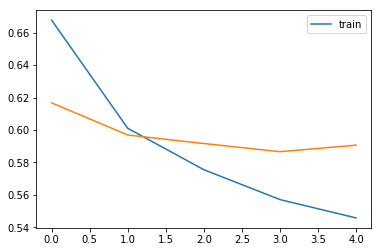

In [19]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

In [20]:
model_mvsoft.save("aux.h5")

### Infer Labels (without predictive model)

In [15]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

confe_matrix_G = get_Global_confusionM(Z_train,label_I.y_obs_repeat)

if y_obs.shape[1] <= 12000:
    ds_labels,ds_conf = label_I.DS_labels()

Representation for MV in 0.116856 sec
Representation for DS in 0.065963 sec
Estimation MV in 0.000467 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -14653.167042256031
2 	 -13799.355137438279 	0.0437	0.259030	0.058268
3 	 -13743.942426302658 	0.0171	0.135132	0.004016
4 	 -13734.486476957558 	0.0083	0.096952	0.000688
5 	 -13731.737228510072 	0.0047	0.066205	0.000200
6 	 -13730.743830870631 	0.0029	0.047743	0.000072
7 	 -13730.308987607652 	0.0018	0.036592	0.000032
8 	 -13730.081076716144 	0.0012	0.028339	0.000017
Class marginals
[0.5 0.5]
Estimation for DS in 3.575960 sec


In [25]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.8895779155831166
ACC D&S on train: 0.9151830366073215


In [26]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(X_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvsoft.predict_classes(X_train)
Z_test_pred = model_mvsoft.predict_classes(X_test)

Trained model over soft-MV, Epochs to converge = 5


In [16]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(X_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvhard.predict_classes(X_train)
Z_test_pred = model_mvhard.predict_classes(X_test)

Trained model over hard-MV, Epochs to converge = 6


In [32]:
model_ds = clone_UB.get_model()
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(X_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_ds.predict_classes(X_train)
Z_test_pred = model_ds.predict_classes(X_test)

Trained model over D&S, Epochs to converge = 17


### Raykar Model (joint predict model)

In [23]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (4999, 203, 2)


In [24]:
raykarMC = RaykarMC(max_L, y_obs_categorical.shape[-1], T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("default rnn text", embed=embedding_matrix)

logL_hists,i_r = raykarMC.multiples_run(20,X_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Initializing new EM...
Betas shape:  (203, 2, 2)
Q estimate shape:  (4999, 2)
Iter 1/50 
M step: done,  E step: done //  (in 3.70 sec)	logL: -14124.199	
Iter 2/50 
M step: done,  E step: done //  (in 1.09 sec)	logL: -12691.454	Tol1: 0.10144	Tol2: 0.18036	
Iter 3/50 
M step: done,  E step: done //  (in 1.07 sec)	logL: -12437.879	Tol1: 0.01998	Tol2: 0.05311	
Iter 4/50 
M step: done,  E step: done //  (in 1.05 sec)	logL: -12217.074	Tol1: 0.01775	Tol2: 0.02611	
Finished training
Initializing new EM...
Betas shape:  (203, 2, 2)
Q estimate shape:  (4999, 2)
Iter 1/50 
M step: done,  E step: done //  (in 3.00 sec)	logL: -14058.684	
Iter 2/50 
M step: done,  E step: done //  (in 1.08 sec)	logL: -12751.912	Tol1: 0.09295	Tol2: 0.18174	
Iter 3/50 
M step: done,  E step: done //  (in 1.07 sec)	logL: -12447.818	Tol1: 0.02385	Tol2: 0.05651	
Iter 4/50 
M step: done,  E step: done //  (in 1.04 sec)	logL: -12246.297	Tol1: 0.01619	Tol2: 0.01802	
Finished training
Initializing new EM...
Betas shape:  (20

In [25]:
Z_train_p = raykarMC.get_predictions(X_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_test_p = raykarMC.get_predictions(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

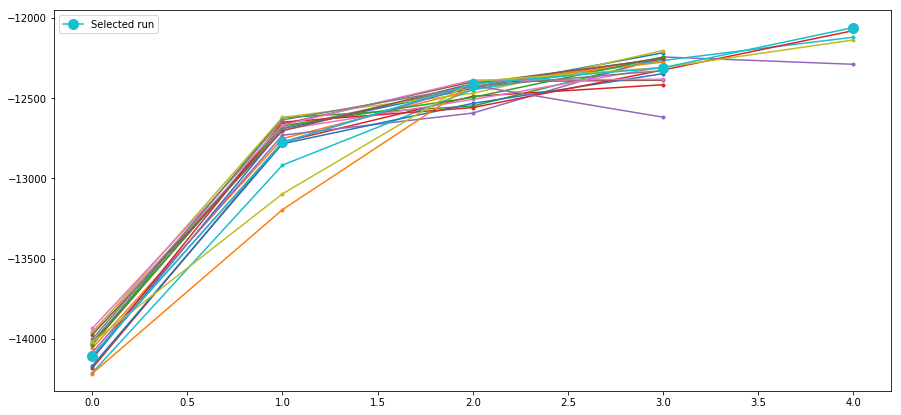

In [26]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Our Proposed

In [78]:
from code.MixtureofGroups import GroupMixtureGlo, GroupMixtureInd

In [79]:
""" AÑADIR A ARCHIVO GROUPS..."""
def define_uniform_groups(power, r, M):
    R_total = r.sum()
    uniform_groups = np.asarray([power*R_total/M for _ in range(M)])
    return uniform_groups

#get our representation 
r_obs = set_representation(y_obs,"repeat")
confe_matrix_G = get_Global_confusionM(Z_train,r_obs)

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 5]
 [5 0]
 [4 2]
 ...
 [2 4]
 [1 4]
 [3 2]]
shape: (4999, 2)


There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.006591 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (4999, 2)
Betas:  (5, 2, 2)
Q estimate:  (4999, 2, 5, 2)
Iter 1/0
M step: done,  E step: done //  (in 1.49 sec)	logL: -19351.873	
Finished training!


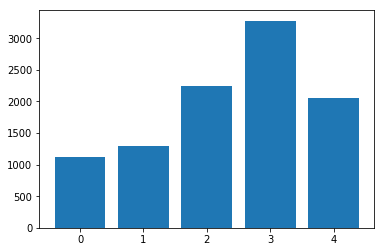

<BarContainer object of 5 artists>

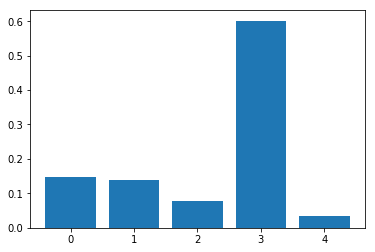

In [22]:
gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=5,epochs=0,optimizer=OPT,dtype_op=DTYPE_OP) 

gMixture_Global.define_model("default rnn text", embed=embedding_matrix)

logL_hists,i_r = gMixture_Global.multiples_run(1,X_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,tolerance=TOL)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())

In [ ]:
#select M based on JS on train and accuracy on val (as train has ground truth can evaluate JS)
from code.evaluation import Evaluation_metrics
logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence1_Mchange = [] #JS Weighted
divergence2_Mchange = [] #JS
probGt_Mchange = []
inertia_Mchange = [] 

uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
uniform = True
for M_seted in range(1,10+1):
    for _ in range(10):
        gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
        gMixture_Global.define_model("default rnn text", embed=embedding_matrix)
        
        if uniform:
            #to uniform groups...
            gMixture_Global.define_priors("laplace")
            gMixture_Global.define_priors(uniform_groups) 
        
        logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL)
        
        print("Model with %d trained"%(M_seted))
        logL_Mchange.append(logL_hists[i_r])
        probas_Mchange.append(gMixture_Global.get_alpha())

        #measure metrics..
        evaluate = Evaluation_metrics(gMixture_Global,'our1',plot=False) 
        aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
        Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
        results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs)

        accTR_Mchange.append(results1[0]["Accuracy"][0])
        divergence1_Mchange.append(results1[0]["Mean NormF"][0])
        divergence2_Mchange.append(results1[0]["Mean JS"][0])
        probGt_Mchange.append(prob_Gt)

        c_M = gMixture_Global.get_confusionM()
        y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
        Z_val_pred = gMixture_Global.base_model.predict_classes(Xstd_val)
        results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

        best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
        accTE_Mchange.append(results2[1]["Accuracy"][0])
        inertia_Mchange.append(evaluate.inertia)
        
        del gMixture_Global,logL_hists,evaluate,predictions_m,prob_Gt,prob_Yzt,Z_train_pred,results1,results2,Z_val_pred
        gc.collect()
        keras.backend.clear_session()
# cada 10 obtener promedio
T_models = 9
R = 10
logL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]
accTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
accTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
best_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
probas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
divergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
divergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
probGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
inertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]

In [ ]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange
            )

In [ ]:
#T if i know T
print(T)
M_values = range(1,1+len(logL_Mchange))
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

In [24]:
M_seted = 3 #??

uniform = False
if uniform:
    uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
    print(uniform_groups)

In [25]:
gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("default rnn text", embed=embedding_matrix)

if uniform:
    gMixture_Global.define_priors("laplace")
    gMixture_Global.define_priors(uniform_groups)

logL_hists,i_r = gMixture_Global.multiples_run(20,X_train,r_obs,
                                               batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.006256 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (4999, 2)
Betas:  (3, 2, 2)
Q estimate:  (4999, 2, 3, 2)
Iter 1/50
M step: done,  E step: done //  (in 3.13 sec)	logL: -19102.927	
Iter 2/50
M step: done,  E step: done //  (in 0.89 sec)	logL: -18944.338	Tol1: 0.00830	Tol2: 0.33977	Tol3: 0.00770	
Iter 3/50
M step: done,  E step: done //  (in 0.88 sec)	logL: -18743.027	Tol1: 0.01063	Tol2: 0.16703	Tol3: 0.00672	
Iter 4/50
M step: done,  E step: done //  (in 0.90 sec)	logL: -18617.517	Tol1: 0.00670	Tol2: 0.11656	Tol3: 0.00802	
Iter 5/50
M step: done,  E step: done //  (in 0.96 sec)	logL: -18450.706	Tol1: 0.00896	Tol2: 0.09191	Tol3: 0.01198	
Iter 6/50
M step: done,  E step: done //  (in 0.88 sec)	logL: -18249.667	Tol1: 0.01090	Tol2: 0.07873	Tol3: 0.01770	
Iter 7/50
M step: done,  E step: done //  (in 0.90 sec)	logL: -18065.401	Tol1: 0.01010	Tol2: 0.06952	Tol3: 0.01629	
Iter 8/50
M step: done,  E step: done /

M step: done,  E step: done //  (in 0.87 sec)	logL: -18978.179	Tol1: 0.00666	Tol2: 0.33937	Tol3: 0.00689	
Iter 3/50
M step: done,  E step: done //  (in 0.83 sec)	logL: -18913.062	Tol1: 0.00343	Tol2: 0.16791	Tol3: 0.00791	
Iter 4/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -18572.943	Tol1: 0.01798	Tol2: 0.13707	Tol3: 0.04678	
Iter 5/50
M step: done,  E step: done //  (in 0.87 sec)	logL: -18497.577	Tol1: 0.00406	Tol2: 0.09161	Tol3: 0.01074	
Iter 6/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -18162.942	Tol1: 0.01809	Tol2: 0.11657	Tol3: 0.06850	
Iter 7/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -18070.463	Tol1: 0.00509	Tol2: 0.06948	Tol3: 0.01494	
Iter 8/50
M step: done,  E step: done //  (in 0.83 sec)	logL: -17909.843	Tol1: 0.00889	Tol2: 0.08321	Tol3: 0.04836	
Iter 9/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -17726.107	Tol1: 0.01026	Tol2: 0.08359	Tol3: 0.04825	
Iter 10/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -17569.554	Tol1: 0.

M step: done,  E step: done //  (in 0.98 sec)	logL: -16979.005	Tol1: 0.00950	Tol2: 0.10184	Tol3: 0.06228	
Iter 20/50
M step: done,  E step: done //  (in 0.91 sec)	logL: -16833.601	Tol1: 0.00856	Tol2: 0.03768	Tol3: 0.02088	
Iter 21/50
M step: done,  E step: done //  (in 0.93 sec)	logL: -16774.797	Tol1: 0.00349	Tol2: 0.03392	Tol3: 0.01709	
Iter 22/50
M step: done,  E step: done //  (in 0.90 sec)	logL: -16813.037	Tol1: 0.00228	Tol2: 0.03587	Tol3: 0.02052	
Iter 23/50
M step: done,  E step: done //  (in 0.86 sec)	logL: -16618.272	Tol1: 0.01158	Tol2: 0.10814	Tol3: 0.06610	
Iter 24/50
M step: done,  E step: done //  (in 0.87 sec)	logL: -16550.777	Tol1: 0.00406	Tol2: 0.07198	Tol3: 0.04292	
Iter 25/50
M step: done,  E step: done //  (in 0.92 sec)	logL: -16469.669	Tol1: 0.00490	Tol2: 0.03148	Tol3: 0.01777	
Iter 26/50
M step: done,  E step: done //  (in 0.80 sec)	logL: -16537.531	Tol1: 0.00412	Tol2: 0.03890	Tol3: 0.02332	
Iter 27/50
M step: done,  E step: done //  (in 0.87 sec)	logL: -16369.103	T

M step: done,  E step: done //  (in 0.85 sec)	logL: -17701.703	Tol1: 0.00779	Tol2: 0.12007	Tol3: 0.07520	
Iter 13/50
M step: done,  E step: done //  (in 0.84 sec)	logL: -17468.301	Tol1: 0.01319	Tol2: 0.09879	Tol3: 0.06184	
Iter 14/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -17351.583	Tol1: 0.00668	Tol2: 0.04756	Tol3: 0.02730	
Iter 15/50
M step: done,  E step: done //  (in 0.86 sec)	logL: -17262.984	Tol1: 0.00511	Tol2: 0.07539	Tol3: 0.04583	
Iter 16/50
M step: done,  E step: done //  (in 0.84 sec)	logL: -17145.209	Tol1: 0.00682	Tol2: 0.04625	Tol3: 0.02467	
Iter 17/50
M step: done,  E step: done //  (in 0.87 sec)	logL: -17083.209	Tol1: 0.00362	Tol2: 0.03655	Tol3: 0.01740	
Iter 18/50
M step: done,  E step: done //  (in 0.87 sec)	logL: -16965.432	Tol1: 0.00689	Tol2: 0.04999	Tol3: 0.03069	
Iter 19/50
M step: done,  E step: done //  (in 0.84 sec)	logL: -16983.066	Tol1: 0.00104	Tol2: 0.03557	Tol3: 0.01751	
Iter 20/50
M step: done,  E step: done //  (in 0.82 sec)	logL: -16778.956	T

M step: done,  E step: done //  (in 0.86 sec)	logL: -18063.355	Tol1: 0.00722	Tol2: 0.06942	Tol3: 0.01519	
Iter 8/50
M step: done,  E step: done //  (in 0.84 sec)	logL: -17904.794	Tol1: 0.00878	Tol2: 0.08214	Tol3: 0.04530	
Iter 9/50
M step: done,  E step: done //  (in 0.89 sec)	logL: -17907.022	Tol1: 0.00012	Tol2: 0.05945	Tol3: 0.02414	
Iter 10/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -17690.923	Tol1: 0.01207	Tol2: 0.08183	Tol3: 0.05020	
Iter 11/50
M step: done,  E step: done //  (in 0.86 sec)	logL: -17546.128	Tol1: 0.00818	Tol2: 0.05508	Tol3: 0.02241	
Iter 12/50
M step: done,  E step: done //  (in 0.83 sec)	logL: -17317.797	Tol1: 0.01301	Tol2: 0.08905	Tol3: 0.05535	
Iter 13/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -17196.538	Tol1: 0.00700	Tol2: 0.04751	Tol3: 0.02067	
Iter 14/50
M step: done,  E step: done //  (in 0.83 sec)	logL: -17112.529	Tol1: 0.00489	Tol2: 0.05169	Tol3: 0.03093	
Iter 15/50
M step: done,  E step: done //  (in 0.84 sec)	logL: -17047.206	Tol

M step: done,  E step: done //  (in 0.81 sec)	logL: -17601.562	Tol1: 0.00986	Tol2: 0.11401	Tol3: 0.07136	
Iter 12/50
M step: done,  E step: done //  (in 0.82 sec)	logL: -17463.706	Tol1: 0.00783	Tol2: 0.07265	Tol3: 0.04287	
Iter 13/50
M step: done,  E step: done //  (in 0.81 sec)	logL: -17365.694	Tol1: 0.00561	Tol2: 0.04724	Tol3: 0.01899	
Iter 14/50
M step: done,  E step: done //  (in 0.84 sec)	logL: -17237.322	Tol1: 0.00739	Tol2: 0.04387	Tol3: 0.02001	
Iter 15/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -17131.787	Tol1: 0.00612	Tol2: 0.04130	Tol3: 0.02291	
Iter 16/50
M step: done,  E step: done //  (in 0.83 sec)	logL: -17059.992	Tol1: 0.00419	Tol2: 0.03986	Tol3: 0.01850	
Iter 17/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -16950.884	Tol1: 0.00640	Tol2: 0.04922	Tol3: 0.03119	
Iter 18/50
M step: done,  E step: done //  (in 0.83 sec)	logL: -16896.753	Tol1: 0.00319	Tol2: 0.04742	Tol3: 0.02805	
Iter 19/50
M step: done,  E step: done //  (in 0.85 sec)	logL: -16872.542	T

In [26]:
Z_train_p = gMixture_Global.get_predictions(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.get_predictions(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

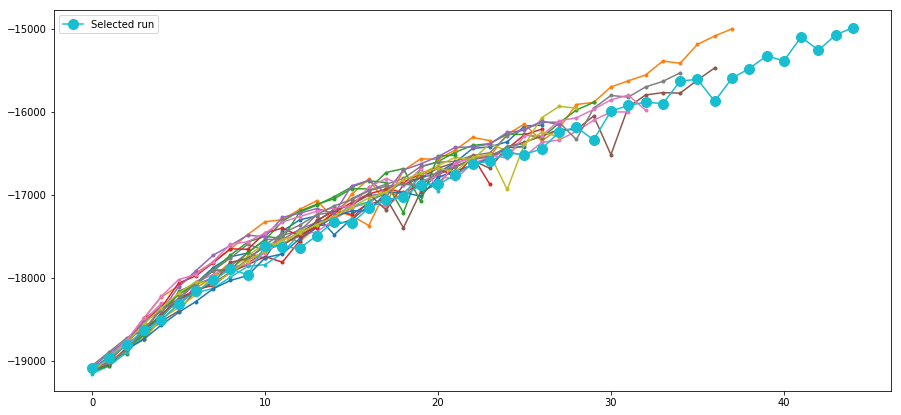

In [27]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [80]:
Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
T_idx_unique = np.arange(T).reshape(-1,1)

A = keras.utils.to_categorical(np.arange(T), num_classes=T) #fast way
print("shape of annotator representation (T, R_t)=", A.shape)

shape of annotator representation (T, R_t)= (203, 203)


shape of annotator representation (T, R_t)= (203, 2)


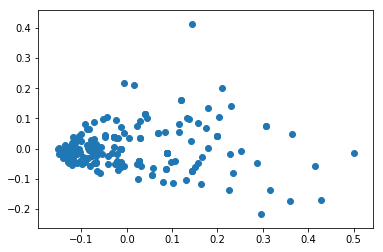

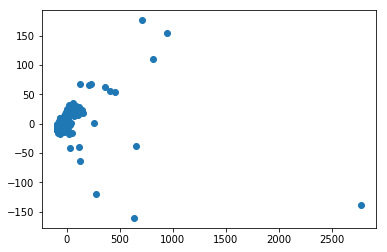

array([[  18.,   17.],
       [ 252.,  213.],
       [  46.,   52.],
       [ 350.,  363.],
       [ 194.,  135.],
       [1610., 2383.],
       [ 637.,  657.],
       [ 148.,  142.],
       [  23.,   22.],
       [ 379.,  407.],
       [  91.,   78.],
       [  56.,   53.],
       [ 121.,  109.],
       [ 630.,  538.],
       [  67.,   77.],
       [ 332.,  328.],
       [  14.,   11.],
       [  80.,   60.],
       [  10.,   19.],
       [  56.,   79.],
       [  64.,   91.],
       [ 127.,   98.],
       [ 105.,  100.],
       [   5.,   10.],
       [  52.,   63.],
       [  48.,   62.],
       [  80.,   65.],
       [ 217.,  276.],
       [  12.,   13.],
       [  11.,   19.],
       [  26.,   34.],
       [  89.,  106.],
       [  28.,   17.],
       [  74.,   76.],
       [  50.,  125.],
       [  86.,  209.],
       [  30.,   40.],
       [  69.,   66.],
       [ 116.,  121.],
       [  62.,   58.],
       [  33.,   22.],
       [  14.,   16.],
       [   4.,   11.],
       [  1

In [81]:
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, r_obs.argmax(axis=-1))

#A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten
A_rep = np.zeros((conf_mat.shape[0], Kl))
for t in range(A_rep.shape[0]):
    A_rep[t] = JS_confmatrixs(conf_mat_norm[t], np.identity(Kl),raw=True) #distancia a I (MV)
    
print("shape of annotator representation (T, R_t)=", A_rep.shape)

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()


A_rep = np.zeros((y_obs.shape[1], Kl))
for i in range(N):
    for l, t_idx in enumerate(T_idx[i]):
        obs_t = Y_ann_train[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
    
from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()
A_rep

In [82]:
#different M_seted??
M_seted = 2

In [85]:
gMixture_Ind1 = GroupMixtureInd(max_L,Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind1.define_model("default rnn text", embed=embedding_matrix)

#gMixture_Ind.define_model_group("mlp", T, M_seted, 1, BatchN=True, embed=True, embed_M=A) #con o sin BN
gMixture_Ind1.define_model_group("perceptron", T, embed=True, embed_M=A, BatchN=True,bias=False)

logL_hists,i_r = gMixture_Ind1.multiples_run(10,X_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.002356 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (4999, 2)
Betas:  (3, 2, 2)
Q estimate:  (27746, 3, 2)
Iter 1/50
M step: done,  E step: done //  (in 5.95 sec)	logL: -17004.676	
Iter 2/50
M step: done,  E step: done //  (in 1.53 sec)	logL: -15813.108	Tol1: 0.07007	Tol2: 0.16775	
Iter 3/50
M step: done,  E step: done //  (in 1.50 sec)	logL: -14931.188	Tol1: 0.05577	Tol2: 0.15502	
Iter 4/50
M step: done,  E step: done //  (in 1.60 sec)	logL: -14515.067	Tol1: 0.02787	Tol2: 0.12398	
Iter 5/50
M step: done,  E step: done //  (in 1.57 sec)	logL: -14461.433	Tol1: 0.00370	Tol2: 0.10197	
Iter 6/50
M step: done,  E step: done //  (in 1.46 sec)	logL: -13656.745	Tol1: 0.05564	Tol2: 0.14788	
Iter 7/50
M step: done,  E step: done //  (in 1.56 sec)	logL: -13224.931	Tol1: 0.03162	Tol2: 0.07016	
Iter 8/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 1.44 sec)	logL: -10779.137	Tol1: 0.01685	Tol2: 0.06725	
Iter 20/50
M step: done,  E step: done //  (in 1.46 sec)	logL: -10693.113	Tol1: 0.00798	Tol2: 0.06611	
Iter 21/50
M step: done,  E step: done //  (in 1.47 sec)	logL: -10587.732	Tol1: 0.00986	Tol2: 0.07506	
Iter 22/50
M step: done,  E step: done //  (in 1.47 sec)	logL: -10435.968	Tol1: 0.01433	Tol2: 0.07271	
Iter 23/50
M step: done,  E step: done //  (in 1.50 sec)	logL: -10348.264	Tol1: 0.00840	Tol2: 0.06499	
Iter 24/50
M step: done,  E step: done //  (in 1.46 sec)	logL: -10353.279	Tol1: 0.00048	Tol2: 0.05751	
Iter 25/50
M step: done,  E step: done //  (in 1.46 sec)	logL: -10189.659	Tol1: 0.01580	Tol2: 0.04719	
Iter 26/50
M step: done,  E step: done //  (in 1.43 sec)	logL: -10176.024	Tol1: 0.00134	Tol2: 0.05341	
Iter 27/50
M step: done,  E step: done //  (in 1.43 sec)	logL: -10165.008	Tol1: 0.00108	Tol2: 0.07414	
Iter 28/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -10041.162	Tol1: 0.01

Pre-train networks over *z* on 3 epochs... Done!
MV init:  (4999, 2)
Betas:  (3, 2, 2)
Q estimate:  (27746, 3, 2)
Iter 1/50
M step: done,  E step: done //  (in 4.73 sec)	logL: -16927.723	
Iter 2/50
M step: done,  E step: done //  (in 1.45 sec)	logL: -16001.506	Tol1: 0.05472	Tol2: 0.17205	
Iter 3/50
M step: done,  E step: done //  (in 1.48 sec)	logL: -15166.463	Tol1: 0.05219	Tol2: 0.14385	
Iter 4/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -14676.025	Tol1: 0.03234	Tol2: 0.12001	
Iter 5/50
M step: done,  E step: done //  (in 1.43 sec)	logL: -14213.816	Tol1: 0.03149	Tol2: 0.09396	
Iter 6/50
M step: done,  E step: done //  (in 1.52 sec)	logL: -13805.805	Tol1: 0.02871	Tol2: 0.07229	
Iter 7/50
M step: done,  E step: done //  (in 1.53 sec)	logL: -13558.790	Tol1: 0.01789	Tol2: 0.07142	
Iter 8/50
M step: done,  E step: done //  (in 1.45 sec)	logL: -13104.672	Tol1: 0.03349	Tol2: 0.07893	
Iter 9/50
M step: done,  E step: done //  (in 1.48 sec)	logL: -12865.575	Tol1: 0.01825	Tol2: 0.068

In [86]:
Z_train_p = gMixture_Ind1.get_predictions_z(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind1.get_predictions_z(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind1.get_predictions_g(T_idx_unique) 

In [89]:
gMixture_Ind3 = GroupMixtureInd(max_L,Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind3.define_model("default rnn text", embed=embedding_matrix)

gMixture_Ind3.define_model_group("mlp", A_rep.shape[1], Kl*M_seted, 1, BatchN=False, embed=False) #con BN

logL_hists,i_r = gMixture_Ind3.multiples_run(10,X_train,Y_ann_train, T_idx, A=A_rep, batch_size=BATCH_SIZE,
                                   pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL) 

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000290 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs...

KeyboardInterrupt: 

In [ ]:
Z_train_p = gMixture_Ind3.get_predictions_z(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind3.get_predictions_z(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind3.get_predictions_g(A_rep) 

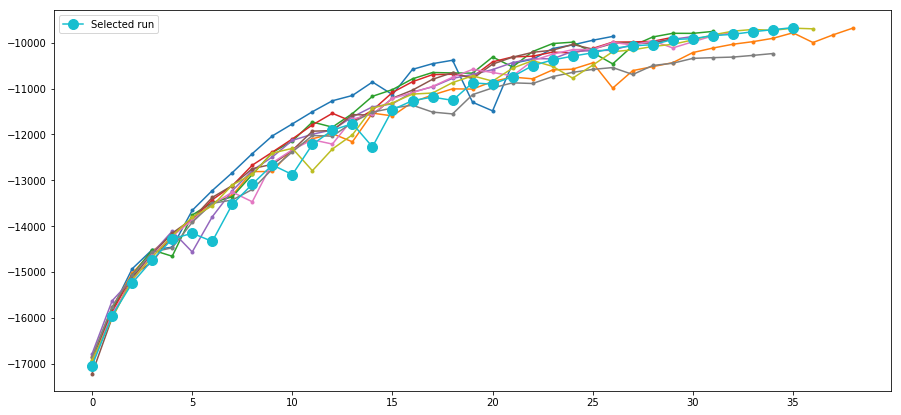

In [87]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [13]:
#Import it:
from code.evaluation import Evaluation_metrics

In [14]:
evaluate = Evaluation_metrics(model_UB,'keras',X_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,1.0,1.0,1.0


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7414,0.7414,0.7408


In [ ]:
#upper bound global confusion matrix..
prob_Yz = generate_confusionM(Z_train_pred, label_I.y_obs_repeat)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

In [ ]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',X_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_probas)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
Calculate confusion matrix on repeat version


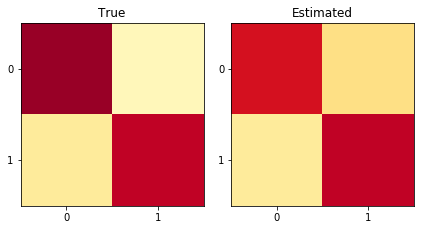

JS divergence: 0.0198	Norm Frobenius: 0.1073


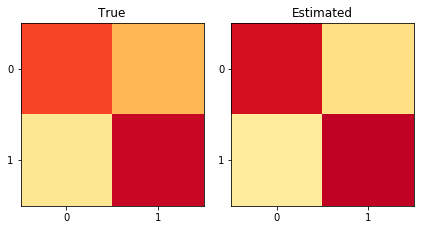

JS divergence: 0.0105	Norm Frobenius: 0.1070


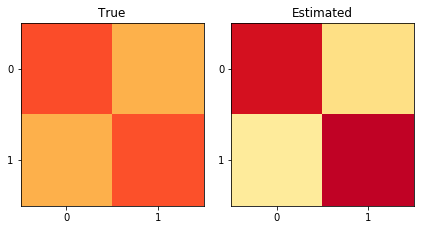

JS divergence: 0.0417	Norm Frobenius: 0.2104


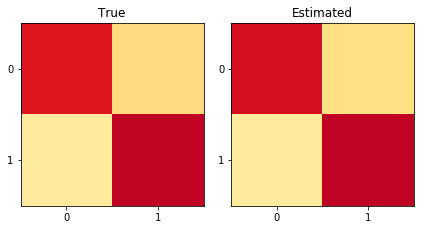

JS divergence: 0.0004	Norm Frobenius: 0.0189


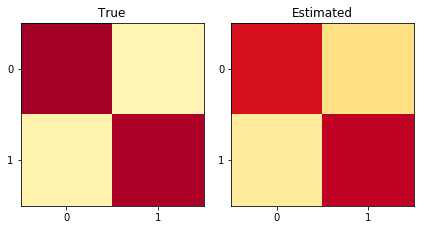

JS divergence: 0.0157	Norm Frobenius: 0.0991


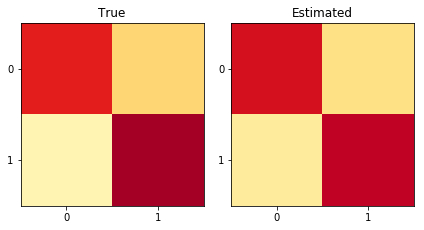

JS divergence: 0.0048	Norm Frobenius: 0.0565


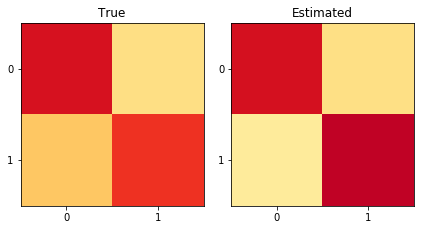

JS divergence: 0.0149	Norm Frobenius: 0.1181


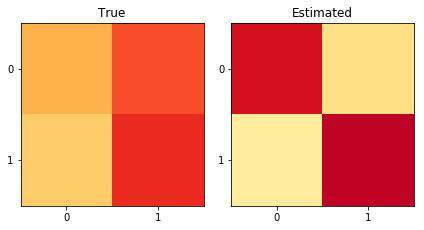

JS divergence: 0.0805	Norm Frobenius: 0.3158


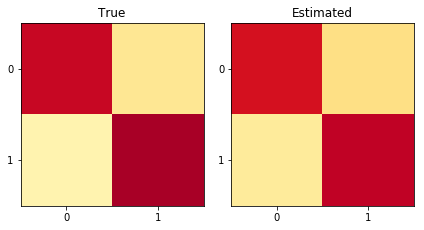

JS divergence: 0.0037	Norm Frobenius: 0.0482


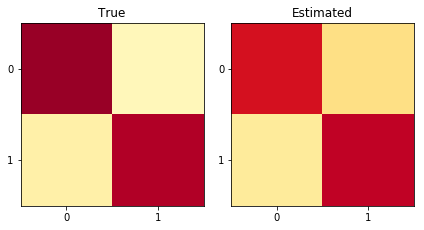

JS divergence: 0.0208	Norm Frobenius: 0.1100


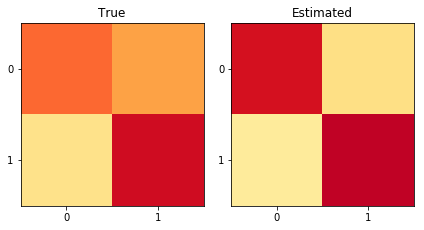

JS divergence: 0.0231	Norm Frobenius: 0.1630


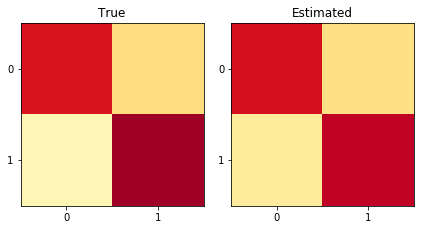

JS divergence: 0.0050	Norm Frobenius: 0.0512


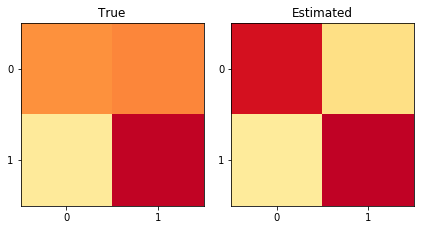

JS divergence: 0.0383	Norm Frobenius: 0.2180


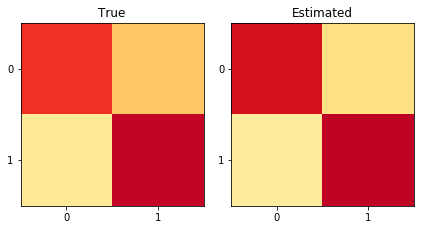

JS divergence: 0.0050	Norm Frobenius: 0.0724


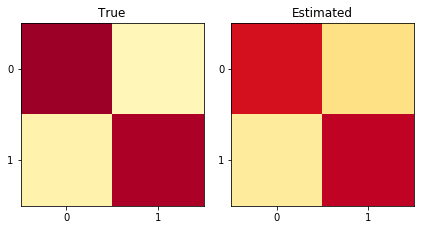

JS divergence: 0.0188	Norm Frobenius: 0.1064
Calculate confusion matrix on global version


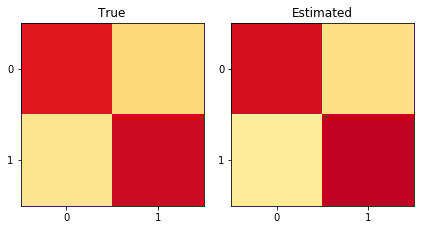

JS divergence: 0.0019	Norm Frobenius: 0.0399
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.7946,0.7946,0.7923,0.1788,0.0601,0.1329,0.0266,0.0399,0.0019


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7419,0.7419,0.7392


In [17]:
evaluate = Evaluation_metrics(model_mvhard,'keras',X_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_onehot, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_onehot)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(model_ds,'keras',X_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = ds_conf.mean(axis=0))

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train
Calculate confusion matrix on repeat version


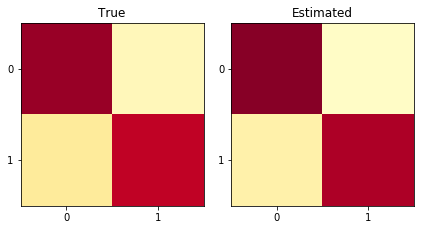

JS divergence: 0.0046	Norm Frobenius: 0.0380


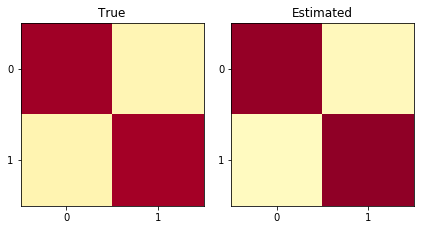

JS divergence: 0.0044	Norm Frobenius: 0.0351


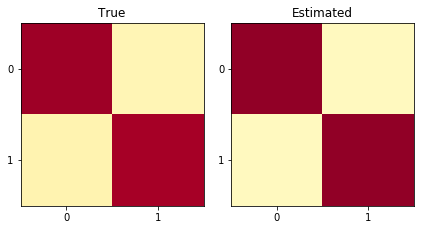

JS divergence: 0.0042	Norm Frobenius: 0.0350


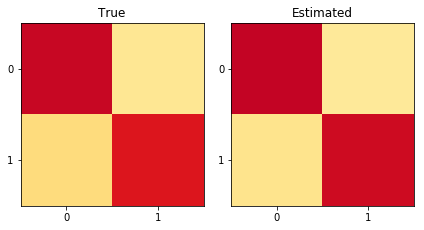

JS divergence: 0.0013	Norm Frobenius: 0.0345


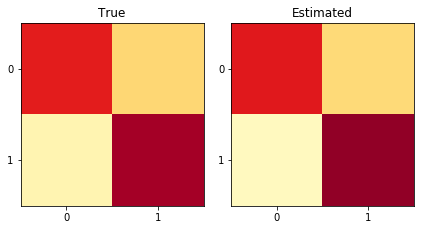

JS divergence: 0.0029	Norm Frobenius: 0.0304


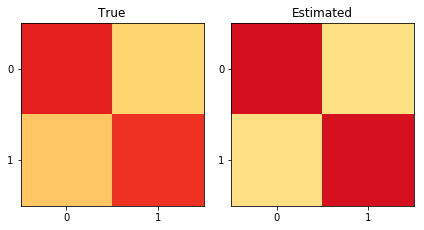

JS divergence: 0.0064	Norm Frobenius: 0.0814


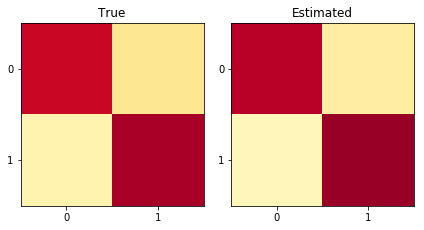

JS divergence: 0.0028	Norm Frobenius: 0.0373


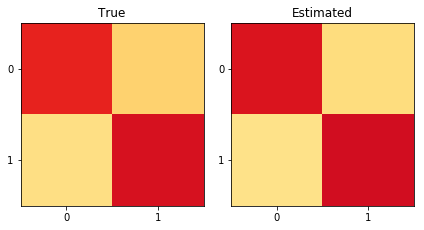

JS divergence: 0.0012	Norm Frobenius: 0.0345


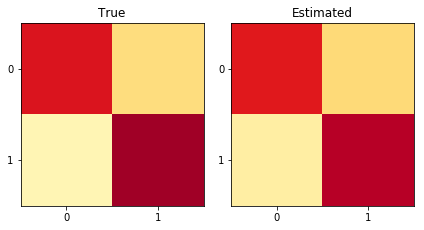

JS divergence: 0.0023	Norm Frobenius: 0.0341


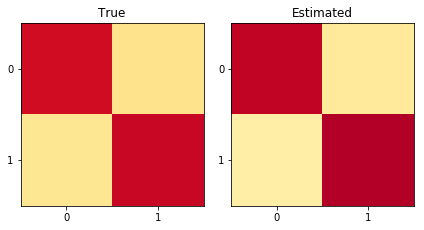

JS divergence: 0.0036	Norm Frobenius: 0.0493


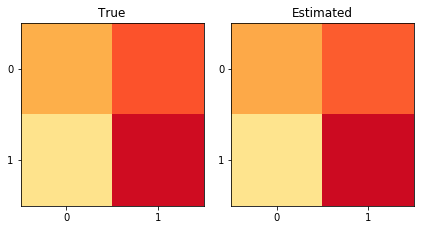

JS divergence: 0.0001	Norm Frobenius: 0.0135


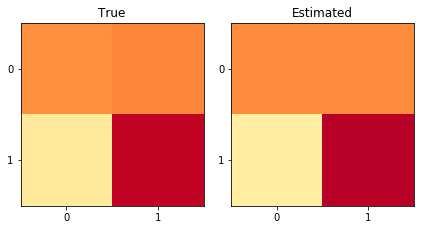

JS divergence: 0.0006	Norm Frobenius: 0.0198


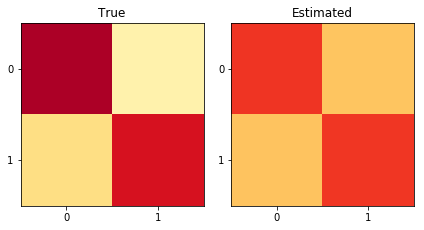

JS divergence: 0.0346	Norm Frobenius: 0.1756


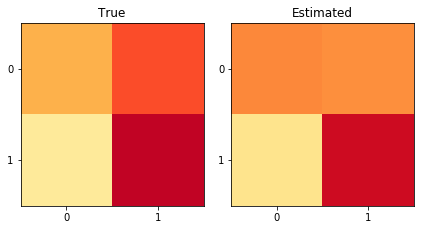

JS divergence: 0.0075	Norm Frobenius: 0.0980


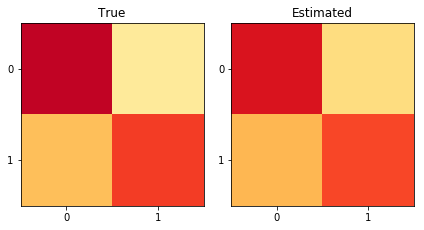

JS divergence: 0.0041	Norm Frobenius: 0.0585
Calculate confusion matrix on global version


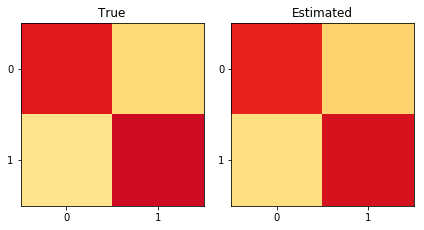

JS divergence: 0.0012	Norm Frobenius: 0.0329
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS,RMSE mean,RMSE w
0,All,0.826,0.826,0.8252,0.09,0.0283,0.0358,0.0038,0.0329,0.0012,0.108,0.094


A result


,ACC imiting Annot mean,Cross-entropy mean,ACC imiting Annot wmean,Cross entropy wmean
0,0.7722,0.4882,0.7567,0.4881


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.8778,0.8778,0.8776


In [27]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(X_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yzt.mean(axis=0))

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(X_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(X_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs (Uniform priors) ***") #groups uniform...

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Individual-T multiples runs***
Train
Calculate confusion matrix on repeat version


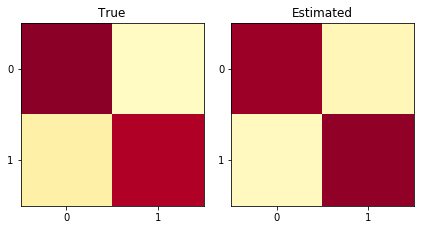

JS divergence: 0.0100	Norm Frobenius: 0.0556
Groups probabilities:  [0.74 0.14 0.12]


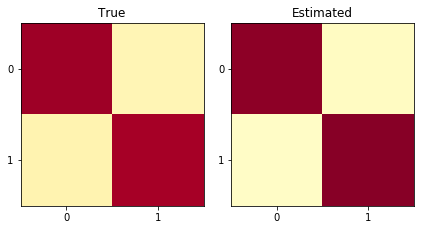

JS divergence: 0.0111	Norm Frobenius: 0.0513
Groups probabilities:  [0.72 0.22 0.06]


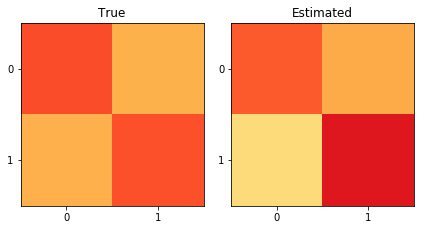

JS divergence: 0.0094	Norm Frobenius: 0.1053
Groups probabilities:  [0.16 0.04 0.8 ]


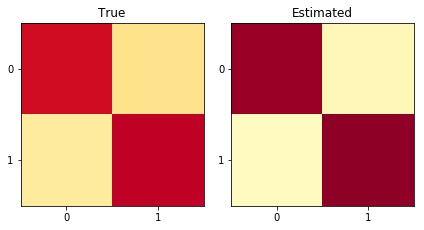

JS divergence: 0.0271	Norm Frobenius: 0.1152
Groups probabilities:  [0.11 0.78 0.11]


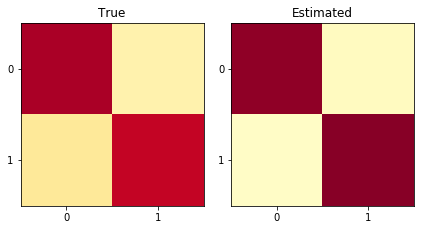

JS divergence: 0.0273	Norm Frobenius: 0.0989
Groups probabilities:  [0.84 0.1  0.06]


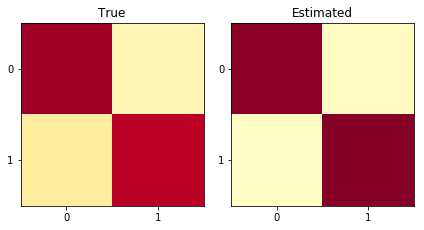

JS divergence: 0.0215	Norm Frobenius: 0.0822
Groups probabilities:  [0.56 0.38 0.06]


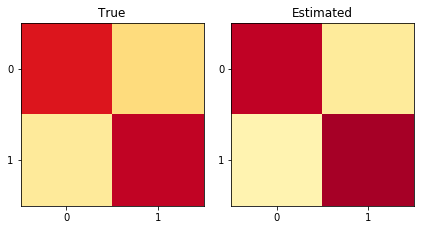

JS divergence: 0.0087	Norm Frobenius: 0.0785
Groups probabilities:  [0.08 0.65 0.27]


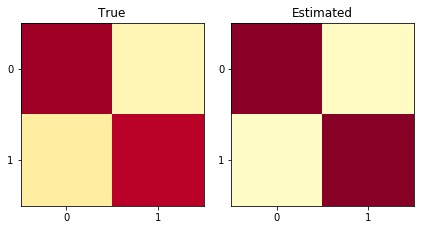

JS divergence: 0.0202	Norm Frobenius: 0.0775
Groups probabilities:  [0.85 0.1  0.05]


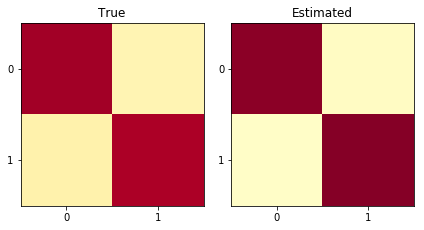

JS divergence: 0.0160	Norm Frobenius: 0.0631
Groups probabilities:  [0.3  0.65 0.05]


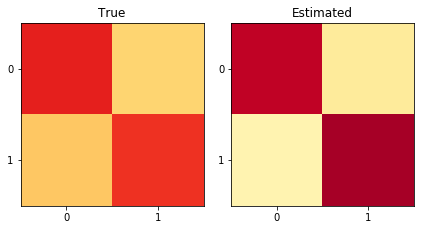

JS divergence: 0.0400	Norm Frobenius: 0.1832
Groups probabilities:  [0.1  0.62 0.28]


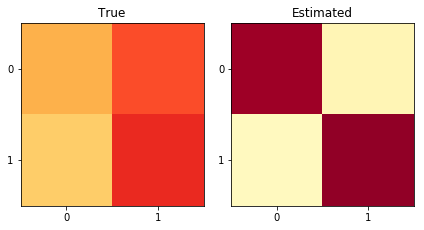

JS divergence: 0.1848	Norm Frobenius: 0.4331
Groups probabilities:  [0.17 0.7  0.13]


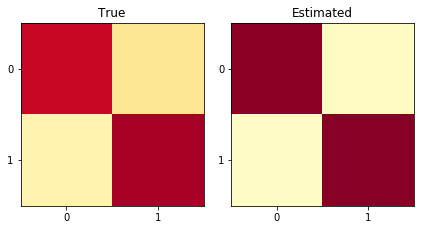

JS divergence: 0.0282	Norm Frobenius: 0.1036
Groups probabilities:  [0.41 0.53 0.06]


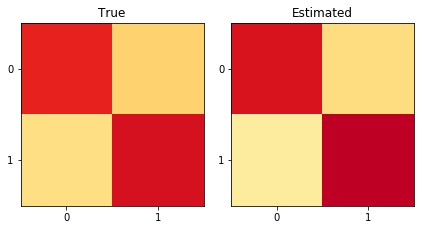

JS divergence: 0.0053	Norm Frobenius: 0.0663
Groups probabilities:  [0.34 0.22 0.44]


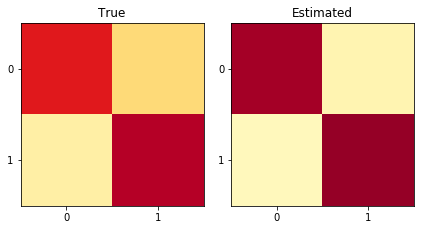

JS divergence: 0.0265	Norm Frobenius: 0.1302
Groups probabilities:  [0.41 0.44 0.15]


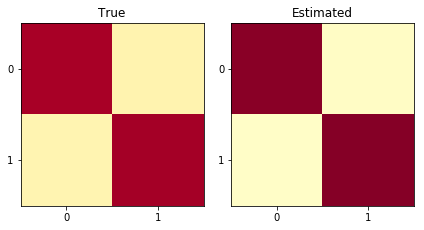

JS divergence: 0.0162	Norm Frobenius: 0.0620
Groups probabilities:  [0.9  0.06 0.04]
Calculate confusion matrix on global version


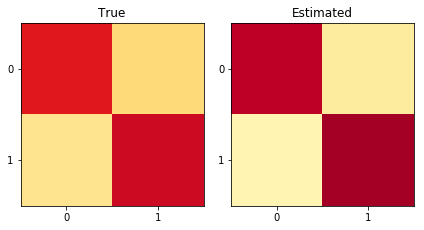

JS divergence: 0.0162	Norm Frobenius: 0.1075
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS,RMSE mean,RMSE w
0,All,0.8988,0.8988,0.8988,0.1745,0.0598,0.1226,0.0253,0.1075,0.0162,0.1258,0.1068


A result


,ACC imiting Annot mean,Cross-entropy mean,ACC imiting Annot wmean,Cross entropy wmean
0,0.8204,0.345,0.8266,0.3486


Test


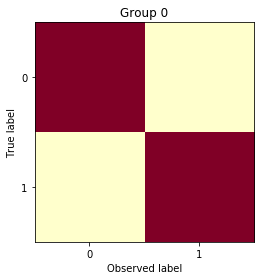

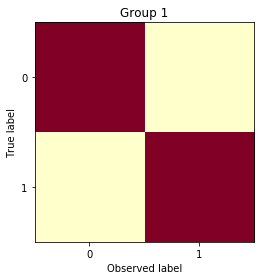

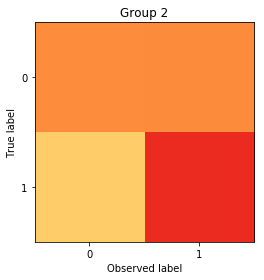

Inertia JS: 0.15712175915321439
Inertia NormF: 0.27323441725712255
A result


,Groups,Prob,T(g),Entropy,Diag mean,Isim (JS),S_raykar,S_bias,C_bias,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.3808,77,0.0035,0.9996,0.9998,0.9992,0.0000,1,0.1571,0.2732,0.8985,0.8985
1,1,0.3600,73,0.0051,0.9994,0.9997,0.9988,0.0001,1,0.1571,0.2732,0.8985,0.8985
2,2,0.2592,52,0.6488,0.6032,0.7617,0.2065,0.1043,1,0.1571,0.2732,0.5588,0.5588


A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.8985,0.8985,0.8978


In [88]:
evaluate = Evaluation_metrics(gMixture_Ind1,'our1') 
aux = gMixture_Ind1.calculate_extra_components(X_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind1.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual-T multiples runs***")

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind1.get_confusionM()
y_o_groups = gMixture_Ind1.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1') 
aux = gMixture_Ind3.calculate_extra_components(X_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind3.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual-K multiples runs***")

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Ind3.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

### project confusion matrices

In [42]:
def flatten_conf(m):
    return m.reshape(m.shape[0], np.prod(m.shape[1:]))

to_plot = flatten_conf(confe_matrix_R)

centroids_plot_G = flatten_conf(gMixture_Global.get_confusionM())
centroids_plot_I2 = flatten_conf(gMixture_Ind2.get_confusionM())
centroids_plot_I3 = flatten_conf(gMixture_Ind3.get_confusionM())

from sklearn.decomposition import PCA
model = PCA(2)

to_plot = model.fit_transform(to_plot)
centroids_plot_G = model.transform(centroids_plot_G)
centroids_plot_I2 = model.transform(centroids_plot_I2)
centroids_plot_I3 = model.transform(centroids_plot_I3)

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Centroids Global")
plt.scatter(centroids_plot_I2[:,0], centroids_plot_I2[:,1],s=150, marker="X", color='magenta',label="Centroids Individual 2")
plt.scatter(centroids_plot_I3[:,0], centroids_plot_I3[:,1], s=150, marker="X", color='hotpink',label="Centroids Individual 3")

plt.legend()
plt.show()

In [ ]:
##plotear probabilidades de matriz  de conf..